In [1]:
from sklearn.base import OutlierMixin
from sklearn.metrics.pairwise import KERNEL_PARAMS
from xgboost import XGBRegressor
import xgboost as xgb
import pandas as pd
import numpy as np
import sklearn as sklearn
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from sklearn.kernel_ridge import KernelRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import *
from sklearn.neighbors import LocalOutlierFactor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
import biosppy.signals.ecg as ecg
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight

# LOAD THE DATASET

In [2]:
x_data = pd.read_csv('X_train.csv')
y_data = pd.read_csv('y_train.csv')
x_test = pd.read_csv('X_test.csv')

print('Pandas read shape = ' + str(x_data.shape))

print('Test Set',np.argwhere(np.any(np.isnan(x_test))))

x_data = x_data.to_numpy()[:, 1:]  #convert the data frame to numpy array
y_data = y_data.to_numpy()[:, 1]  #convert the data frame to numpy array\
x_test = x_test.to_numpy()[:, 1:]


Pandas read shape = (5117, 17843)
Test Set []


# SPLIT THE DATASET

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.25, random_state=36)

# EXTRACT HEARTBEAT TEMPLATES AND RPEAK LOCATIONS

In [22]:
rpeaks_train = []
heartbeats_train = []
for i in range(x_train.shape[0]):
    temp = x_train[i,:]
    rpeaks_train_ind = ecg.hamilton_segmenter(temp[np.logical_not(np.isnan(temp))], 300)['rpeaks']      ####ENGZEE_SEGMENTER RESULTED IN EMPTY ARRAYS
    heartbeats_train.append(ecg.extract_heartbeats(temp[np.logical_not(np.isnan(temp))], sampling_rate = 300, rpeaks=rpeaks_train_ind)['templates'])
    rpeaks_train.append(ecg.extract_heartbeats(temp[np.logical_not(np.isnan(temp))], sampling_rate = 300, rpeaks=rpeaks_train_ind)['rpeaks'])
    #print(i)

rpeaks_train = np.array(rpeaks_train)
heartbeats_train = np.array(heartbeats_train)

/var/folders/mj/kcb9f_n104z8fw8t77lzvcv80000gn/T/ipykernel_949/4067803072.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rpeaks_train = np.array(rpeaks_train)
/var/folders/mj/kcb9f_n104z8fw8t77lzvcv80000gn/T/ipykernel_949/4067803072.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  heartbeats_train = np.array(heartbeats_train)


In [20]:
counter = 0
for i in range(rpeaks_train.shape[0]):
    if rpeaks_train[i].size == 0:
        counter += 1
        print(rpeaks_train[i])
print(counter)


[]
[]
[]
[]
[]
[]
[]
[]
[]
9


In [11]:
rpeaks_val = []
heartbeats_val = []
for i in range(x_val.shape[0]):
    temp = x_val[i,:]
    rpeaks_val_ind = ecg.hamilton_segmenter(temp[np.logical_not(np.isnan(temp))], 300)['rpeaks']     ####ENGZEE_SEGMENTER RESULTED IN EMPTY ARRAYS
    heartbeats_val.append(ecg.extract_heartbeats(temp[np.logical_not(np.isnan(temp))], sampling_rate = 300, rpeaks=rpeaks_val_ind)['templates'])
    rpeaks_val.append(ecg.extract_heartbeats(temp[np.logical_not(np.isnan(temp))], sampling_rate = 300, rpeaks=rpeaks_val_ind)['rpeaks'])
    #print(i)

rpeaks_val = np.array(rpeaks_val)
heartbeats_val = np.array(heartbeats_val)


/var/folders/mj/kcb9f_n104z8fw8t77lzvcv80000gn/T/ipykernel_949/1297802285.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rpeaks_val = np.array(rpeaks_val)
/var/folders/mj/kcb9f_n104z8fw8t77lzvcv80000gn/T/ipykernel_949/1297802285.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  heartbeats_val = np.array(heartbeats_val)


In [12]:
rpeaks_test = []
heartbeats_test = []
for i in range(x_test.shape[0]):
    temp = x_test[i,:]
    rpeaks_test_ind = ecg.hamilton_segmenter(temp[np.logical_not(np.isnan(temp))], 300)['rpeaks']     ####ENGZEE_SEGMENTER RESULTED IN EMPTY ARRAYS
    heartbeats_test.append(ecg.extract_heartbeats(temp[np.logical_not(np.isnan(temp))], sampling_rate = 300, rpeaks=rpeaks_test_ind)['templates'])
    rpeaks_test.append(ecg.extract_heartbeats(temp[np.logical_not(np.isnan(temp))], sampling_rate = 300, rpeaks=rpeaks_test_ind)['rpeaks'])
    #print(i)

rpeaks_test = np.array(rpeaks_test)
heartbeats_test = np.array(heartbeats_test)

/var/folders/mj/kcb9f_n104z8fw8t77lzvcv80000gn/T/ipykernel_949/3373129269.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rpeaks_test = np.array(rpeaks_test)
/var/folders/mj/kcb9f_n104z8fw8t77lzvcv80000gn/T/ipykernel_949/3373129269.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  heartbeats_test = np.array(heartbeats_test)


(329, 180)
(329,)
[[ -63.  -65.  -67. ...  -10.  -12.  -13.]
 [   2.    2.    1. ...   41.   44.   46.]
 [  -5.   -5.   -6. ...  115.  112.  107.]
 ...
 [ -19.  -19.  -18. ...   -8.   -7.   -6.]
 [-123. -120. -118. ...    0.    1.    2.]
 [   4.    3.    3. ...   93.   95.   96.]]
[  70  204  221  234  252  337  495  496  526  612  619  679  772  782
  801  882  884  890 1043 1051 1072 1156 1164 1310 1325 1345 1354 1430
 1590 1601 1624 1706 1868 1899 1979 1996 2136 2144 2169 2172 2254 2411
 2424 2444 2530 2533 2690 2703 2722 2805 2965 2975 2996 3076 3248 3274
 3358 3523 3534 3554 3637 3675 3699 3795 3805 3825 3908 4023 4069 4070
 4101 4183 4188 4190 4352 4362 4382 4473 4565 4630 4636 4659 4744 4899
 4931 4934 5012 5022 5175 5184 5205 5288 5450 5463 5482 5568 5728 5759
 5840 5996 6027 6110 6117 6143 6269 6277 6300 6382 6487 6551 6559 6579
 6638 6660 6677 6693 6818 6831 6852 6935 7093 7105 7127 7209 7219 7373
 7382 7405 7491 7492 7494 7570 7655 7663 7684 7768 7931 7942 7962 8047
 8215 82

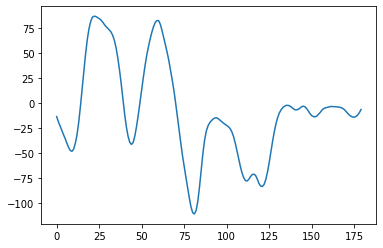

In [13]:
mu = np.mean(heartbeats_val[48], axis=0)
plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')

print(heartbeats_val[5].shape)
print(rpeaks_val[5].shape)
print(heartbeats_val[0])
print(rpeaks_val[0])
print(heartbeats_val.shape)
print(rpeaks_val.shape)
print(np.diff(rpeaks_train[48], axis=0))
print(rpeaks_train[48])
temp = x_train[48,:]
rpeaks_train_ind_45 = ecg.christov_segmenter(temp[np.logical_not(np.isnan(temp))], 300)['rpeaks']
print(rpeaks_train_ind_45)
##EACH PEAK IN THE TIME SERIES OF AN INDIVIDUAL IS TAKEN AS SEPERATE TEMPLATES

# PREPROCESS THE DATA - PREPARE THE FEAURES

In [15]:
#EXTRACT THE FEATURES IN THE SLIDES FROM THE TEMPLATES
#EXTRACT THE MEAN, VARIANCE, MIN, MAX ETC STATISTICS OF THE TAMPLATES
#OR MAAYBE USE MEAN/MEDIAN TEMPLATE FOR EACH INDIVIDUAL INCIRPORAE WITH LSTM???
#EXTRACT THE MEAN, VARIANCE, MIN, MAX IN THE DURATIONS OF HERTBEATS, IE DIFFERENCES OF RPEAKS
#MAYBE USE THE WHOLE RPKEAS_DIFF VECTOR AS A FEATURE VECTORS TO INDICATE RR INTERVALS AS A TIME SERIES OF DIFFERENCE OF TWO TIME SERIES PROBLEM:BUT NOT OF THE SAME SIZE!!!

rpeaks_duration_mean = np.zeros(rpeaks_train.shape[0])
heart_rate_variability = np.zeros(rpeaks_train.shape[0])
rpeaks_duration_median = np.zeros(rpeaks_train.shape[0])
rpeaks_duration_min = np.zeros(rpeaks_train.shape[0])
rpeaks_duration_max = np.zeros(rpeaks_train.shape[0])

for i in range(rpeaks_train.shape[0]):
    rpeak_diff_i = np.diff(rpeaks_train[i], axis=0)
    if len(rpeak_diff_i) == 0:
        print('yes')
        rpeak_diff_i = rpeaks_train[i]
    #print(i)
    rpeaks_duration_mean[i] = np.mean(rpeak_diff_i, axis=0)
    heart_rate_variability[i] = np.var(rpeak_diff_i, axis=0)
    rpeaks_duration_median[i] = np.median(rpeak_diff_i, axis=0)
    rpeaks_duration_min[i] = np.min(rpeak_diff_i, axis=0)
    rpeaks_duration_max[i] = np.max(rpeak_diff_i, axis=0)

r_amplitude_mean = np.zeros(heartbeats_train.shape[0])
r_amplitude_median = np.zeros(heartbeats_train.shape[0])
r_amplitude_min = np.zeros(heartbeats_train.shape[0])
r_amplitude_max = np.zeros(heartbeats_train.shape[0])
r_amplitude_var = np.zeros(heartbeats_train.shape[0])
q_amplitude_mean = np.zeros(heartbeats_train.shape[0])
q_amplitude_median = np.zeros(heartbeats_train.shape[0])
q_amplitude_min = np.zeros(heartbeats_train.shape[0])
q_amplitude_max = np.zeros(heartbeats_train.shape[0])
q_amplitude_var = np.zeros(heartbeats_train.shape[0])

for i in range(heartbeats_train.shape[0]):
    r_amplitudes_i = np.max(heartbeats_train[i], axis=1)            ####FORGOT TO REPLACE R_AMPLITUDE_I AND Q_AMPLITUDE_I!!!!!!!
    q_amplitudes_i = np.min(heartbeats_train[i], axis=1)
    #print(r_amplitudes_i.shape)
    r_amplitude_mean[i] = np.mean(r_amplitudes_i)
    r_amplitude_median[i] = np.median(r_amplitudes_i)
    r_amplitude_min[i] = np.min(r_amplitudes_i)
    r_amplitude_max[i] = np.max(r_amplitudes_i)
    r_amplitude_var[i] = np.var(r_amplitudes_i)
    q_amplitude_mean[i] = np.mean(q_amplitudes_i)
    q_amplitude_median[i] = np.median(q_amplitudes_i)
    q_amplitude_min[i] = np.min(q_amplitudes_i)
    q_amplitude_max[i] = np.max(q_amplitudes_i)
    q_amplitude_var[i] = np.var(q_amplitudes_i)

x_train_features = np.column_stack((rpeaks_duration_mean, rpeaks_duration_median, heart_rate_variability, rpeaks_duration_min, rpeaks_duration_max, \
    r_amplitude_mean, r_amplitude_median, r_amplitude_var, r_amplitude_min, r_amplitude_max, q_amplitude_mean, q_amplitude_median, \
        q_amplitude_var, q_amplitude_min, q_amplitude_max))

print(x_train_features)
print(x_train_features.shape)

yes


/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/envs/aml/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [9]:
rpeaks_duration_mean = np.zeros(rpeaks_val.shape[0])
heart_rate_variability = np.zeros(rpeaks_val.shape[0])
rpeaks_duration_median = np.zeros(rpeaks_val.shape[0])
rpeaks_duration_min = np.zeros(rpeaks_val.shape[0])
rpeaks_duration_max = np.zeros(rpeaks_val.shape[0])

for i in range(rpeaks_val.shape[0]):
    rpeak_diff_i = np.diff(rpeaks_val[i], axis=0)
    if len(rpeak_diff_i) == 0:
        print('yes')
        rpeak_diff_i = rpeaks_val[i]
    #print(i)
    rpeaks_duration_mean[i] = np.mean(rpeak_diff_i, axis=0)
    heart_rate_variability[i] = np.var(rpeak_diff_i, axis=0)
    rpeaks_duration_median[i] = np.median(rpeak_diff_i, axis=0)
    rpeaks_duration_min[i] = np.min(rpeak_diff_i, axis=0)
    rpeaks_duration_max[i] = np.max(rpeak_diff_i, axis=0)

r_amplitude_mean = np.zeros(heartbeats_val.shape[0])
r_amplitude_median = np.zeros(heartbeats_val.shape[0])
r_amplitude_min = np.zeros(heartbeats_val.shape[0])
r_amplitude_max = np.zeros(heartbeats_val.shape[0])
r_amplitude_var = np.zeros(heartbeats_val.shape[0])
q_amplitude_mean = np.zeros(heartbeats_val.shape[0])
q_amplitude_median = np.zeros(heartbeats_val.shape[0])
q_amplitude_min = np.zeros(heartbeats_val.shape[0])
q_amplitude_max = np.zeros(heartbeats_val.shape[0])
q_amplitude_var = np.zeros(heartbeats_val.shape[0])

for i in range(heartbeats_val.shape[0]):
    r_amplitudes_i = np.max(heartbeats_val[i], axis=1)
    q_amplitudes_i = np.min(heartbeats_val[i], axis=1)
    #print(r_amplitudes_i.shape)
    r_amplitude_mean[i] = np.mean(r_amplitudes_i)
    r_amplitude_median[i] = np.median(r_amplitudes_i)
    r_amplitude_min[i] = np.min(r_amplitudes_i)
    r_amplitude_max[i] = np.max(r_amplitudes_i)
    r_amplitude_var[i] = np.var(r_amplitudes_i)
    q_amplitude_mean[i] = np.mean(q_amplitudes_i)
    q_amplitude_median[i] = np.median(q_amplitudes_i)
    q_amplitude_min[i] = np.min(q_amplitudes_i)
    q_amplitude_max[i] = np.max(q_amplitudes_i)
    q_amplitude_var[i] = np.var(q_amplitudes_i)

x_val_features = np.column_stack((rpeaks_duration_mean, rpeaks_duration_median, heart_rate_variability, rpeaks_duration_min, rpeaks_duration_max, \
    r_amplitude_mean, r_amplitude_median, r_amplitude_var, r_amplitude_min, r_amplitude_max, q_amplitude_mean, q_amplitude_median, \
        q_amplitude_var, q_amplitude_min, q_amplitude_max))

print(x_val_features)
print(x_val_features.shape)

[[ 2.75733333e+02  2.75500000e+02  1.17288889e+01 ...  3.36439271e+04
  -1.45000000e+02  1.15200000e+03]
 [ 2.92285714e+02  2.93000000e+02  7.77551020e+00 ...  2.27664849e+04
  -3.79000000e+02  8.69000000e+02]
 [ 2.49322581e+02  2.61000000e+02  1.26047659e+03 ...  4.10816189e+05
  -3.63500000e+03  4.38400000e+03]
 ...
 [ 3.08680000e+02  3.00000000e+02  3.39133760e+03 ...  3.56446453e+04
  -1.09900000e+03  7.25000000e+02]
 [ 2.39806452e+02  2.41000000e+02  4.54285120e+02 ...  2.17374280e+04
  -2.93000000e+02  6.77000000e+02]
 [ 2.46516129e+02  2.55000000e+02  1.54573361e+03 ...  1.23421591e+04
  -4.75000000e+02  1.48600000e+03]]
(1280, 15)


In [10]:
rpeaks_duration_mean = np.zeros(rpeaks_test.shape[0])
heart_rate_variability = np.zeros(rpeaks_test.shape[0])
rpeaks_duration_median = np.zeros(rpeaks_test.shape[0])
rpeaks_duration_min = np.zeros(rpeaks_test.shape[0])
rpeaks_duration_max = np.zeros(rpeaks_test.shape[0])

for i in range(rpeaks_test.shape[0]):
    rpeak_diff_i = np.diff(rpeaks_test[i], axis=0)
    if len(rpeak_diff_i) == 0:
        print('yes')
        rpeak_diff_i = rpeaks_test[i]
    #print(i)
    rpeaks_duration_mean[i] = np.mean(rpeak_diff_i, axis=0)
    heart_rate_variability[i] = np.var(rpeak_diff_i, axis=0)
    rpeaks_duration_median[i] = np.median(rpeak_diff_i, axis=0)
    rpeaks_duration_min[i] = np.min(rpeak_diff_i, axis=0)
    rpeaks_duration_max[i] = np.max(rpeak_diff_i, axis=0)

r_amplitude_mean = np.zeros(heartbeats_test.shape[0])
r_amplitude_median = np.zeros(heartbeats_test.shape[0])
r_amplitude_min = np.zeros(heartbeats_test.shape[0])
r_amplitude_max = np.zeros(heartbeats_test.shape[0])
r_amplitude_var = np.zeros(heartbeats_test.shape[0])
q_amplitude_mean = np.zeros(heartbeats_test.shape[0])
q_amplitude_median = np.zeros(heartbeats_test.shape[0])
q_amplitude_min = np.zeros(heartbeats_test.shape[0])
q_amplitude_max = np.zeros(heartbeats_test.shape[0])
q_amplitude_var = np.zeros(heartbeats_test.shape[0])

for i in range(heartbeats_test.shape[0]):
    r_amplitudes_i = np.max(heartbeats_test[i], axis=1)
    q_amplitudes_i = np.min(heartbeats_test[i], axis=1)
    #print(r_amplitudes_i.shape)
    r_amplitude_mean[i] = np.mean(r_amplitudes_i)
    r_amplitude_median[i] = np.median(r_amplitudes_i)
    r_amplitude_min[i] = np.min(r_amplitudes_i)
    r_amplitude_max[i] = np.max(r_amplitudes_i)
    r_amplitude_var[i] = np.var(r_amplitudes_i)
    q_amplitude_mean[i] = np.mean(q_amplitudes_i)
    q_amplitude_median[i] = np.median(q_amplitudes_i)
    q_amplitude_min[i] = np.min(q_amplitudes_i)
    q_amplitude_max[i] = np.max(q_amplitudes_i)
    q_amplitude_var[i] = np.var(q_amplitudes_i)

x_test_features = np.column_stack((rpeaks_duration_mean, rpeaks_duration_median, heart_rate_variability, rpeaks_duration_min, rpeaks_duration_max, \
    r_amplitude_mean, r_amplitude_median, r_amplitude_var, r_amplitude_min, r_amplitude_max, q_amplitude_mean, q_amplitude_median, \
        q_amplitude_var, q_amplitude_min, q_amplitude_max))

print(x_test_features)
print(x_test_features.shape)

[[ 2.57258065e+02  2.52000000e+02  3.03352758e+02 ...  1.06846780e+05
  -6.93000000e+02  1.71300000e+03]
 [ 3.22058824e+02  3.21000000e+02  4.24055363e+02 ...  4.24821838e+04
  -1.70000000e+02  1.09300000e+03]
 [ 2.43030303e+02  2.71000000e+02  1.22803930e+04 ...  8.66286711e+04
  -1.13300000e+03  1.35600000e+03]
 ...
 [ 2.27376812e+02  2.27000000e+02  2.91684100e+02 ...  2.03783255e+04
  -5.90000000e+02  6.77000000e+02]
 [ 2.19305556e+02  2.20000000e+02  5.43441358e+00 ...  1.05126852e+04
  -1.61000000e+02  6.53000000e+02]
 [ 1.77304348e+02  1.68500000e+02  1.38838563e+03 ...  6.07700977e+04
  -1.21700000e+03  1.70900000e+03]]
(3411, 15)


# FINDING UNBALANCED CLASS WEIGHTS

In [11]:
weights_per_class = compute_class_weight(class_weight = 'balanced', classes = [0,1,2,3], y = y_train)
print(weights_per_class)

[0.42407162 2.88063063 0.85800537 7.7358871 ]


In [12]:
weights_per_sample = np.zeros(len(y_train))
weights_per_sample[y_train == 0] = weights_per_class[0]
weights_per_sample[y_train == 1] = weights_per_class[1]
weights_per_sample[y_train == 2] = weights_per_class[2]
weights_per_sample[y_train == 3] = weights_per_class[3]
print(weights_per_sample)
print(y_train)

[0.42407162 0.85800537 0.42407162 ... 2.88063063 0.42407162 0.85800537]
[0 2 0 ... 1 0 2]


# DEFINE F1 SCORE FUNCTION

In [13]:
def f1_eval(estimator,y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred), average='micro')
    return 'f1_err', err

# CROSS VALIDATION FOR XGBOOST

In [16]:
model = xgb.XGBClassifier(random_state=42, use_label_encoder = False, objective='multi:softmax', eval_metric = 'mlogloss')
#model = xgb.XGBRFClassifier(random_state=42, use_label_encoder = False, objective='multi:softmax', eval_metric = 'mlogloss')
n_estimator_list = [80, 300, 500]
subsample_list = [0.3,0.5,0.7]
colsample_bynode_list = [0.3,0.5,0.7]
learning_rate_list = [0.04, 0.1, 0.2]
reg_alpha_list = [0.1,1,5]
reg_lambda_list = [0.1,1,5]
max_depth_list = [5,8]
gamma_list = [0.1, 0.2]

param_dict = {'n_estimators': n_estimator_list, 'subsample': subsample_list, 'colsample_bynode': colsample_bynode_list,
              'learning_rate': learning_rate_list, 'reg_alpha':reg_alpha_list, 'max_depth':max_depth_list, 'gamma':gamma_list, 'reg_lambda':reg_lambda_list}

fit_params = {'sample_weight': weights_per_sample}

grid_search = GridSearchCV(model, param_dict, refit=True, cv=4, scoring='f1_micro', verbose=3, error_score = 'raise')

# fit the model using the training data
grid_search.fit(x_train_features, y_train, **fit_params)
print('best parameters:',grid_search.best_params_)

#make predictions with the trained model
y_val_pred = grid_search.predict(x_val_features)
y_train_pred = grid_search.predict(x_train_features)
print('Val_score',f1_score(y_val, y_val_pred, average='micro'))
print('Train_score',f1_score(y_train, y_train_pred, average='micro'))

print('best score:',grid_search.best_score_) 
print(grid_search.cv_results_['split0_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split1_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split2_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split3_test_score'][grid_search.best_index_])

Fitting 4 folds for each of 2916 candidates, totalling 11664 fits
[CV 1/4] END colsample_bynode=0.3, gamma=0.1, learning_rate=0.04, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.704 total time=   0.6s
[CV 2/4] END colsample_bynode=0.3, gamma=0.1, learning_rate=0.04, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.699 total time=   0.6s
[CV 3/4] END colsample_bynode=0.3, gamma=0.1, learning_rate=0.04, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.681 total time=   0.5s
[CV 4/4] END colsample_bynode=0.3, gamma=0.1, learning_rate=0.04, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1, subsample=0.3;, score=0.689 total time=   0.5s
[CV 1/4] END colsample_bynode=0.3, gamma=0.1, learning_rate=0.04, max_depth=5, n_estimators=80, reg_alpha=0.1, reg_lambda=0.1, subsample=0.5;, score=0.698 total time=   0.5s
[CV 2/4] END colsample_bynode=0.3, gamma=0.1, learning_rate=0.04

KeyboardInterrupt: 

# GRIDSEARCH FOR GPCLASSIFIER

In [ ]:
a_array = np.array([5e-2, 8e-2, 1e-1, 2e-1, 3e-1, 4e-1])
b_array = np.array([3,4,5,6,7])
l_array = np.array([3, 4, 5, 6, 7, 8, 9])
nu_array = np.array([0.5, 1.5, 2.5, 5, 10, 40])
length_scale_array = np.array([0.1, 1, 5, 10])


a_array, b_array, l_array, nu_array, length_scale_array = np.meshgrid(a_array, b_array, l_array, nu_array, length_scale_array)
cartesian_product = np.concatenate([a_array.flatten().reshape(-1,1), b_array.flatten().reshape(-1,1), l_array.flatten().reshape(-1,1), nu_array.flatten().reshape(-1,1), length_scale_array.flatten().reshape(-1,1)], axis=1)
param_grid = [{
        "kernel": [ConstantKernel(constant_value=a, constant_value_bounds="fixed")*RBF(l, length_scale_bounds="fixed")+ConstantKernel(constant_value=b, constant_value_bounds="fixed")+Matern(length_scale = length_scale, nu = nu, length_scale_bounds="fixed") for a,b,l,nu,length_scale in cartesian_product]
    }]

gp = GaussianProcessClassifier()

grid_search = GridSearchCV(estimator=gp, param_grid=param_grid, cv=4, scoring='f1_micro', verbose=3)

# fit the model using the training data
grid_search.fit(x_train_features, y_train)
print('best parameters:',grid_search.best_params_)

y_val_pred = grid_search.predict(x_val_features)
y_train_pred = grid_search.predict(x_train_features)
print('Val_score',f1_score(y_val, y_val_pred, average='micro'))
print('Train_score',f1_score(y_train, y_train_pred, average='micro'))

print('best score:',grid_search.best_score_) 
print(grid_search.cv_results_['split0_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split1_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split2_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split3_test_score'][grid_search.best_index_])

Fitting 4 folds for each of 5040 candidates, totalling 20160 fits
[CV 1/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=0.1, nu=0.5);, score=0.590 total time=  24.1s
[CV 2/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=0.1, nu=0.5);, score=0.590 total time=  22.5s
[CV 3/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=0.1, nu=0.5);, score=0.589 total time=  22.8s
[CV 4/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=0.1, nu=0.5);, score=0.589 total time=  21.5s
[CV 1/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=1, nu=0.5);, score=0.590 total time=  21.4s
[CV 2/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=1, nu=0.5);, score=0.590 total time=  21.6s
[CV 3/4] END kernel=0.224**2 * RBF(length_scale=3) + 1.73**2 + Matern(length_scale=1, nu=0.5);, score=0.589 total time=  22.2s
[CV 4/4] END kernel=0.224**2 * RBF(le

# GRIDSEARCH FOR RANDOMFOREST

In [14]:
# Number of trees in random forest
n_estimators = [700, 800 ,900]
# Number of features to consider at every split
max_features = (np.array([0.45, 0.5, 0.55, 0.7])*x_train_features.shape[1]).astype(int)
# Maximum number of levels in tree
max_depth = [20, 24, 28, 32]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [4,5,6,7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
param_dict = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

model = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(model, param_dict, refit=True, cv=4, scoring='f1_micro', verbose = 3)

# fit the model using the training data
grid_search.fit(x_train_features, y_train)
print('best parameters:',grid_search.best_params_)

y_val_pred = grid_search.predict(x_val_features)
y_train_pred = grid_search.predict(x_train_features)
print('Val_score',f1_score(y_val, y_val_pred, average='micro'))
print('Train_score',f1_score(y_train, y_train_pred, average='micro'))

print('best score:',grid_search.best_score_) 
print(grid_search.cv_results_['split0_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split1_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split2_test_score'][grid_search.best_index_])
print(grid_search.cv_results_['split3_test_score'][grid_search.best_index_])



Fitting 4 folds for each of 480 candidates, totalling 1920 fits
[CV 1/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=700;, score=0.739 total time=  10.4s
[CV 2/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=700;, score=0.756 total time=   8.4s
[CV 3/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=700;, score=0.729 total time=   9.3s
[CV 4/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=700;, score=0.728 total time=   9.4s
[CV 1/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.736 total time=  11.0s
[CV 2/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.755 total time=   9.7s
[CV 3/4] END max_depth=20, max_features=6, min_samples_leaf=2, min_samples_split=4, n_estimators=800;, score=0.730 total time=  13.5

KeyboardInterrupt: 

In [17]:
classifier = xgb.XGBClassifier(random_state=42, use_label_encoder = False, objective='multi:softmax', eval_metric = 'mlogloss', colsample_bynode = 0.3, gamma = 0.1, learning_rate = 0.04, max_depth = 4, n_estimators = 550, reg_alpha=1, reg_lambda = 1, subsample = 0.5)
classifier.fit(x_train_features, y_train, sample_weight = weights_per_sample)
y_train_pred = classifier.predict(x_train_features)
y_val_pred = classifier.predict(x_val_features)
y_test_pred = classifier.predict(x_test_features)
print('Val_score_xgboost_2',f1_score(y_val, y_val_pred, average='micro'))
print('Train_score_xgboost_2',f1_score(y_train, y_train_pred, average='micro'))

header = ['id','y']
index_array = np.arange(y_test_pred.shape[0])
submission = np.vstack((index_array,y_test_pred))
print(submission)
print(submission.shape)
df = pd.DataFrame(submission.T)
df.to_csv('submission.csv', index=False, header=header)

Val_score_xgboost_2 0.7421875
Train_score_xgboost_2 0.8548345061245765
[[   0    1    2 ... 3408 3409 3410]
 [   0    2    3 ...    0    0    2]]
(2, 3411)
